In [1]:
import numpy as np
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image1 = os.path.join("data",  "siemens_star.tif")
assert os.path.exists(image1), f"File does not exist: {image1}"

image2 = os.path.join("data", "rectangle_grid.tif")
assert os.path.exists(image2), f"File does not exist: {image2}"


In [3]:
config = {'chip1': {'xoffset': 1,
                    'yoffset': 1,
                    'description': 'top right chip'},
            'chip2': {'xoffset': 0,
                    'yoffset': 0,
                    'description': 'top left and reference chip'},
            'chip3': {'xoffset': 0,
                        'yoffset': 1,
                        'description': 'bottom left chip'},
            'chip4': {'xoffset': 1,
                    'yoffset': 2,
                    'description': 'bottom right chip'}
}

In [4]:
# Load images
data_images1 = np.array(Image.open(image1))
data_images2 = np.array(Image.open(image2))

In [5]:
# data_images1 = data_images2

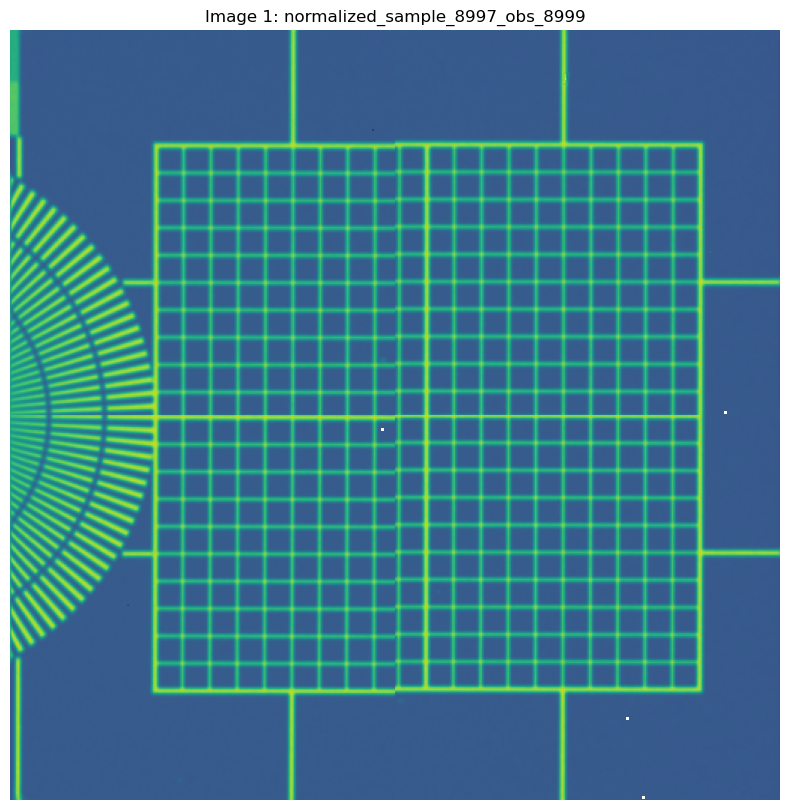

In [6]:
# preview
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data_images1)
ax.set_title("Image 1: normalized_sample_8997_obs_8999")
ax.axis('off')
plt.show()

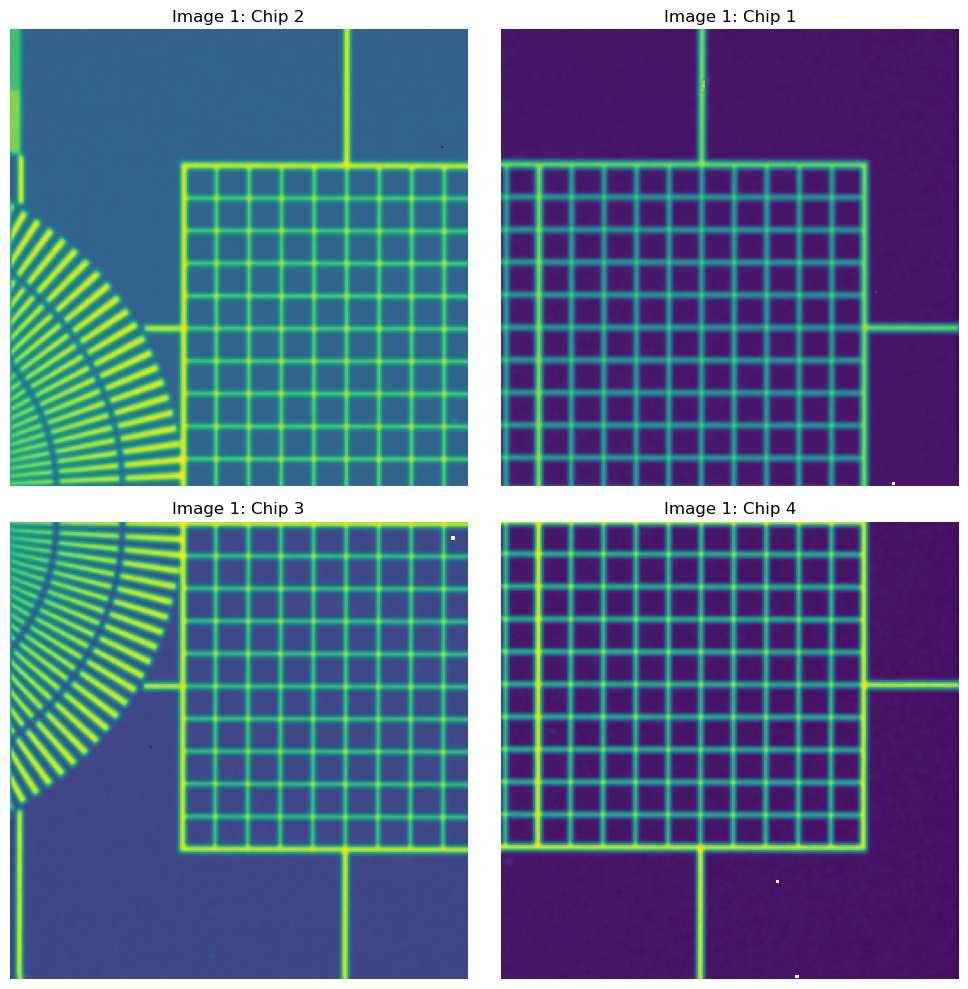

In [7]:
data = {'chip1': data_images1[0:256, 256:],
        'chip2': data_images1[0:256, 0:256],
        'chip3': data_images1[256:, 0:256],
        'chip4': data_images1[256:, 256:]}

chip_size = (256, 256)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axs[0, 1].imshow(data['chip1'])
axs[0, 0].imshow(data['chip2'])
axs[1, 0].imshow(data['chip3'])
axs[1, 1].imshow(data['chip4'])
axs[0, 1].set_title("Image 1: Chip 1")
axs[0, 0].set_title("Image 1: Chip 2")
axs[1, 0].set_title("Image 1: Chip 3")
axs[1, 1].set_title("Image 1: Chip 4")
axs[0, 1].axis('off')
axs[0, 0].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

plt.tight_layout()

In [8]:
# apply correction to each chip
old_image_height, old_image_width = data_images1.shape 

new_image_height = old_image_height + max([config[chip]['yoffset'] for chip in config])
new_image_width = old_image_width + max([config[chip]['xoffset'] for chip in config])

print(f"{old_image_height = } -> {new_image_height = }")
print(f"{old_image_width = } -> {new_image_width = }")

new_data_images1 = np.zeros((new_image_height, new_image_width), dtype=data_images1.dtype)
print(f"{new_data_images1.shape = }")


old_image_height = 512 -> new_image_height = 514
old_image_width = 512 -> new_image_width = 513
new_data_images1.shape = (514, 513)


In [9]:

new_data_images1[0:chip_size[0], 0:chip_size[1]] = data['chip2']
new_data_images1[config['chip1']['yoffset']:chip_size[0] + config['chip1']['yoffset'], 
                 chip_size[1] + config['chip1']['xoffset']:2*chip_size[1] + config['chip1']['xoffset']] = data['chip1']
new_data_images1[chip_size[0] + config['chip3']['yoffset']:2*chip_size[0] + config['chip3']['yoffset'],
                 config['chip3']['xoffset']:chip_size[1] + config['chip3']['xoffset']] = data['chip3']
new_data_images1[chip_size[0] + config['chip4']['yoffset']:2*chip_size[0] + config['chip4']['yoffset'],
                 chip_size[1] + config['chip4']['xoffset']:2*chip_size[1] + config['chip4']['xoffset']] = data['chip4']

Text(0.5, 1.0, 'Original Image 1')

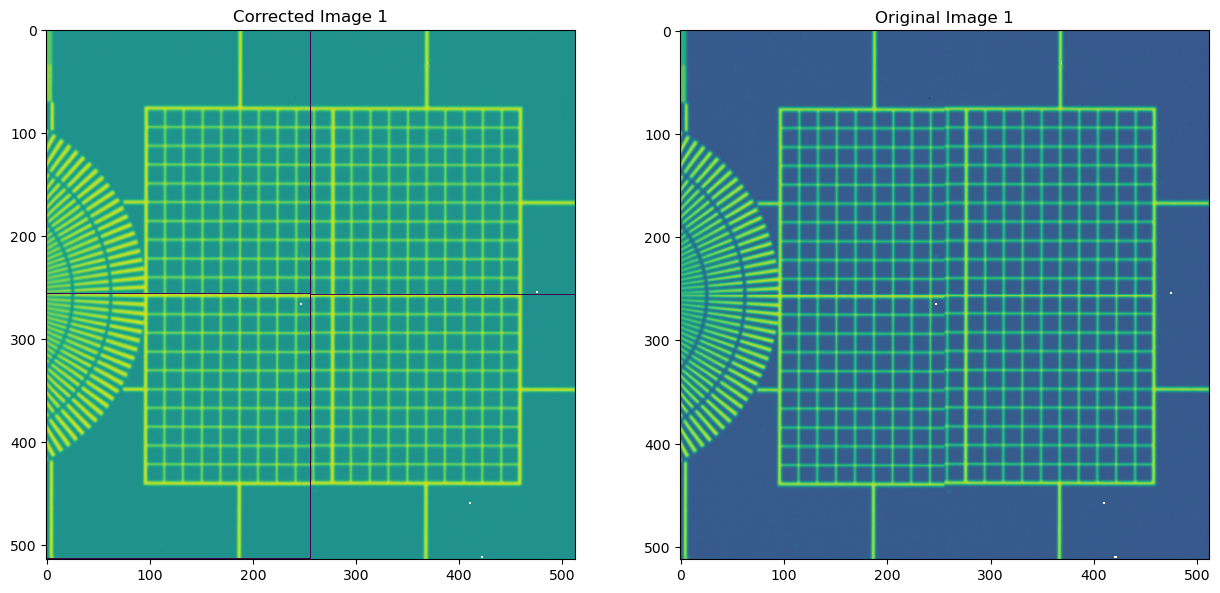

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].imshow(new_data_images1)
axs[0].set_title("Corrected Image 1")
axs[1].imshow(data_images1)
axs[1].set_title("Original Image 1")

In [11]:
xp = np.array([0,2])
yp = np.array([10,20])
interpolated_values = np.interp([1], xp, yp)
print(interpolated_values)

[15.]


In [12]:
print(config)

{'chip1': {'xoffset': 1, 'yoffset': 1, 'description': 'top right chip'}, 'chip2': {'xoffset': 0, 'yoffset': 0, 'description': 'top left and reference chip'}, 'chip3': {'xoffset': 0, 'yoffset': 1, 'description': 'bottom left chip'}, 'chip4': {'xoffset': 1, 'yoffset': 2, 'description': 'bottom right chip'}}


In [13]:
# now we need to fill the gaps between the chips

# between chips 1 and 2, 
# gap is config['chip1']['xoffset'] (horizontal) and config['chip1']['yoffset'] (vertical)
# y will go from 0 to chip_size[0] + config['chip1']['yoffset']
for _y in range(0, chip_size[0] + config['chip1']['yoffset']):
    left_value = new_data_images1[_y, chip_size[0]-1]
    right_value = new_data_images1[_y, chip_size[0] + config['chip1']['xoffset']]

    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(config['chip1']['xoffset'])
    if left_value == 0:
        list_new_value = np.ones(config['chip1']['xoffset']) * right_value
    elif right_value == 0:
        list_new_value = np.ones(config['chip1']['xoffset']) * left_value
    else:
        list_new_value = np.interp(np.arange(1, config['chip1']['xoffset'] + 1), [0, config['chip1']['xoffset'] + 1], [left_value, right_value])

    new_data_images1[_y, chip_size[1]:chip_size[1]+config['chip1']['xoffset']] = list_new_value




In [14]:
# between chips 2 and 3
# gap is config['chip3']['xoffset'] (horizontal) and config['chip3']['yoffset'] (vertical)
# x will go from 0 to chip_size[1] + config['chip3']['xoffset']
for _x in range(0, chip_size[1] + config['chip3']['xoffset']):
    left_value = new_data_images1[chip_size[0]-1, _x]
    right_value = new_data_images1[chip_size[0] + config['chip3']['yoffset'], _x]
    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(config['chip3']['yoffset'])
    if left_value == 0:
        list_new_value = np.ones(config['chip3']['yoffset']) * right_value
    elif right_value == 0:
        list_new_value = np.ones(config['chip3']['yoffset']) * left_value
    else:
        list_new_value = np.interp(np.arange(1, config['chip3']['yoffset'] + 1), [0, config['chip3']['yoffset'] + 1], [left_value, right_value])

    new_data_images1[chip_size[0]:chip_size[0]+config['chip3']['yoffset'], _x] = list_new_value

In [15]:
# between chips 1 and 4
# gap is config['chip4']['xoffset'] - config['chip1']['xoffset'] (horizontal) and config['chip4']['yoffset'] - config['chip1']['yoffset'] (vertical)
# x will go from chip_size[1]+config['chip1']['xoffset'] to 2*chip_size[1]+config['chip1']['xoffset']
for _x in range(chip_size[1] + config['chip1']['xoffset'], 2*chip_size[1] + config['chip1']['xoffset']):
    left_value = new_data_images1[chip_size[0]-1, _x]
    right_value = new_data_images1[chip_size[0] + config['chip4']['yoffset'], _x]
    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(config['chip4']['yoffset'])
    if left_value == 0:
        list_new_value = np.ones(config['chip4']['yoffset']) * right_value
    elif right_value == 0:
        list_new_value = np.ones(config['chip4']['yoffset']) * left_value
    else:
        list_new_value = np.interp(np.arange(1, config['chip4']['yoffset'] + 1), [0, config['chip4']['yoffset'] + 1], [left_value,right_value])

    new_data_images1[chip_size[0]:chip_size[0]+config['chip4']['yoffset'], _x] = list_new_value


In [16]:
# between chips 3 and 4
# gap is config['chip4']['xoffset'] - config['chip3']['xoffset'] (horizontal) and config['chip4']['yoffset'] - config['chip3']['yoffset'] (vertical)
# y will go from chip_size[0]+config['chip3']['yoffset'] to 2*chip_size[0]+config['chip3']['yoffset']
for _y in range(chip_size[0] + config['chip3']['yoffset'], 2*chip_size[0] + config['chip3']['yoffset']):
    left_value = new_data_images1[_y, chip_size[1]-1]
    right_value = new_data_images1[_y, chip_size[1] + config['chip4']['xoffset']]
    if left_value == 0 and right_value == 0:
        list_new_value = np.zeros(config['chip4']['xoffset'])
    if left_value == 0:
        list_new_value = np.ones(config['chip4']['xoffset']) * right_value
    elif right_value == 0:
        list_new_value = np.ones(config['chip4']['xoffset']) * left_value
    else:
        list_new_value = np.interp(np.arange(1, config['chip4']['xoffset'] + 1), [0, config['chip4']['xoffset'] + 1], [left_value,right_value])

    new_data_images1[_y, chip_size[1]:chip_size[1]+config['chip4']['xoffset']+1] = list_new_value

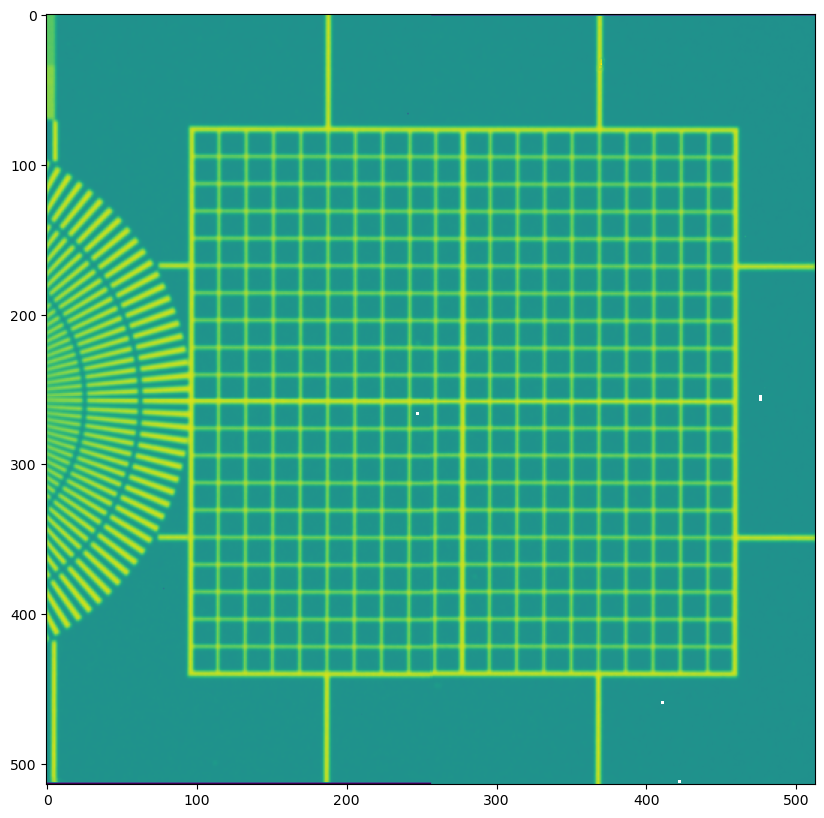

In [17]:
fig, axs = plt.subplots(figsize=(10, 10))
# axs.imshow(new_data_images1[0: chip_size[0], chip_size[1]-2: chip_size[1]+ 4])
axs.imshow(new_data_images1)

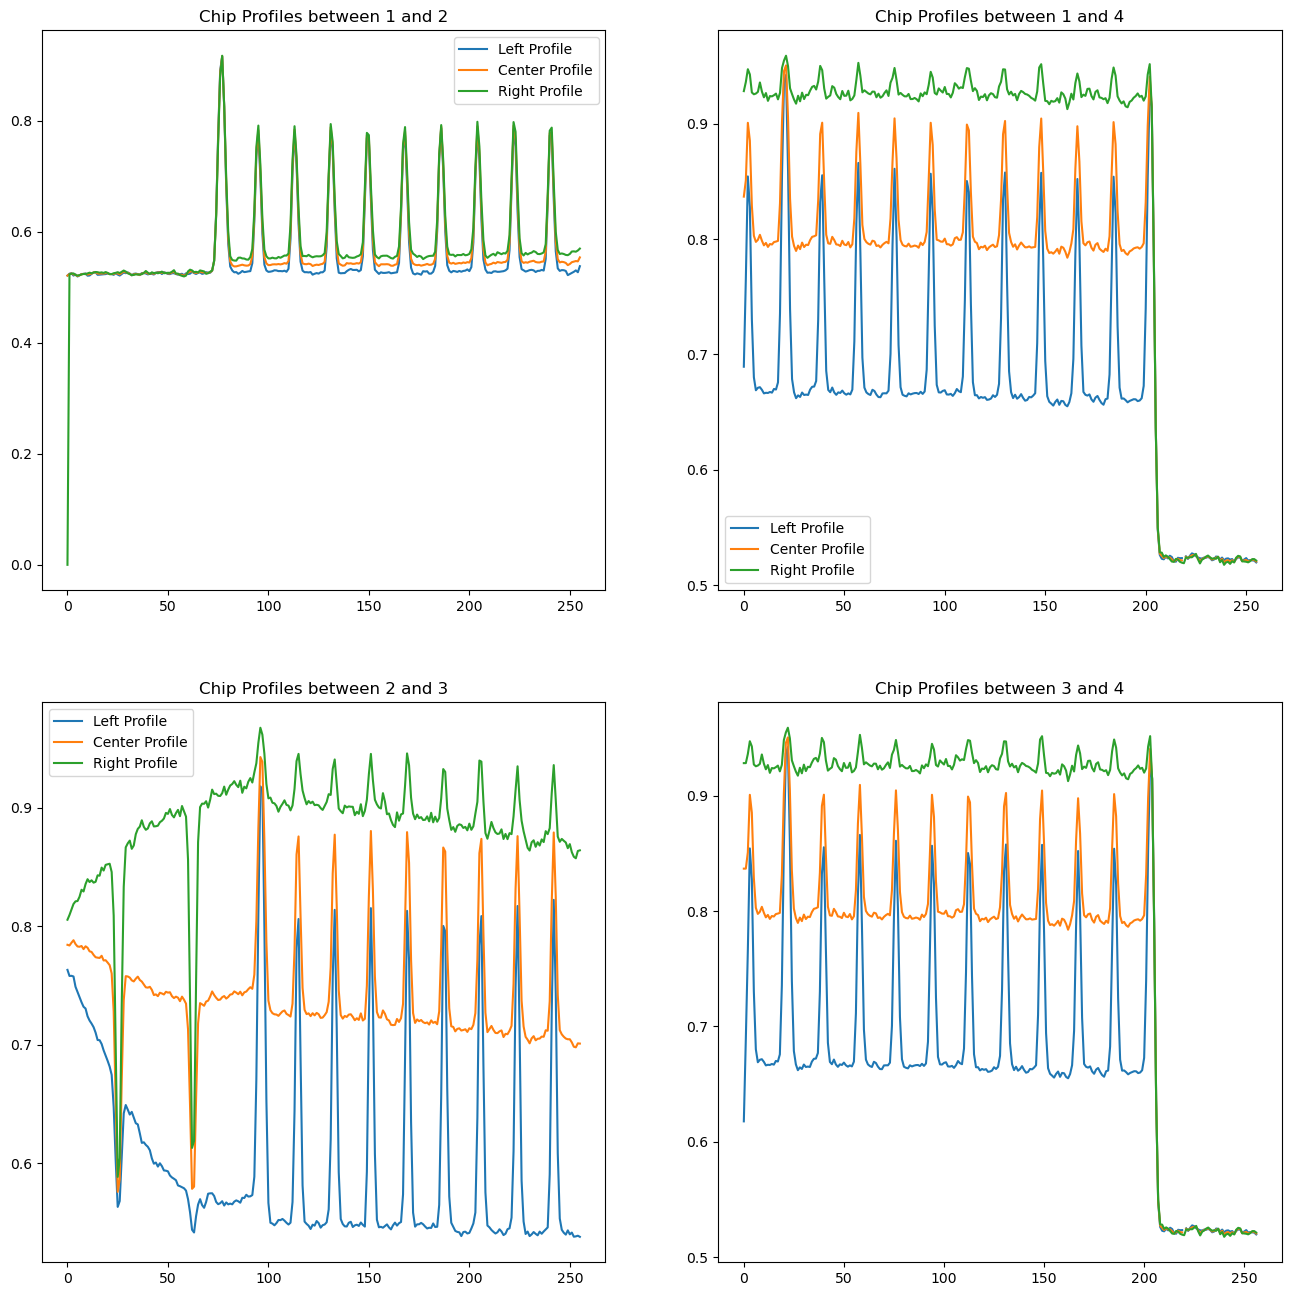

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

# between chips 1 and 2
profile1_left = new_data_images1[0: chip_size[0], chip_size[1]-1]
profile1_center = new_data_images1[0: chip_size[0], chip_size[1] ]
# profile1_right = new_data_images1[0: chip_size[0], chip_size[1] + 1 + config['chip1']['xoffset']]
profile1_right = new_data_images1[0: chip_size[0], chip_size[1] + 1]

axs[0][0].set_title('Chip Profiles between 1 and 2')
axs[0][0].plot(profile1_left, label='Left Profile')
axs[0][0].plot(profile1_center, label='Center Profile')
axs[0][0].plot(profile1_right, label='Right Profile')
axs[0][0].legend()

# between chips 2 and 3
profile2_left = new_data_images1[chip_size[0]-1, 0: chip_size[1]]
profile2_center = new_data_images1[chip_size[0], 0: chip_size[1]]
profile2_right = new_data_images1[chip_size[0]+ 1 + config['chip2']['xoffset'], 0: chip_size[1]]

axs[1][0].set_title('Chip Profiles between 2 and 3')
axs[1][0].plot(profile2_left, label='Left Profile')
axs[1][0].plot(profile2_center, label='Center Profile')
axs[1][0].plot(profile2_right, label='Right Profile')
axs[1][0].legend()

# between chip 1 and 4
profile_3_left = new_data_images1[chip_size[0]+config['chip1']['yoffset']-1, chip_size[1]+config['chip1']['xoffset']: 2*chip_size[1]+ 1 + config['chip1']['xoffset']]
profile_3_center = new_data_images1[chip_size[0]+config['chip1']['yoffset'], chip_size[1]+config['chip1']['xoffset']: 2*chip_size[1]+ 1 + config['chip1']['xoffset']]
profile_3_right = new_data_images1[chip_size[0]+config['chip1']['yoffset']+1, chip_size[1]+config['chip1']['xoffset']: 2*chip_size[1]+ 1 + config['chip1']['xoffset']]
axs[0][1].set_title('Chip Profiles between 1 and 4')
axs[0][1].plot(profile_3_left, label='Left Profile')
axs[0][1].plot(profile_3_center, label='Center Profile')
axs[0][1].plot(profile_3_right, label='Right Profile')
axs[0][1].legend()

# between chip 3 and 4
profile_4_left = new_data_images1[chip_size[0]+config['chip3']['yoffset']-1, chip_size[1]+config['chip3']['xoffset']: 2*chip_size[1]+ 1 + config['chip3']['xoffset']]
profile_4_center = new_data_images1[chip_size[0]+config['chip3']['yoffset'], chip_size[1]+config['chip3']['xoffset']: 2*chip_size[1]+ 1 + config['chip3']['xoffset']]
profile_4_right = new_data_images1[chip_size[0]+config['chip3']['yoffset']+1, chip_size[1]+config['chip3']['xoffset']: 2*chip_size[1]+ 1 + config['chip3']['xoffset']]
axs[1][1].set_title('Chip Profiles between 3 and 4')
axs[1][1].plot(profile_4_left, label='Left Profile')
axs[1][1].plot(profile_4_center, label='Center Profile')
axs[1][1].plot(profile_4_right, label='Right Profile')

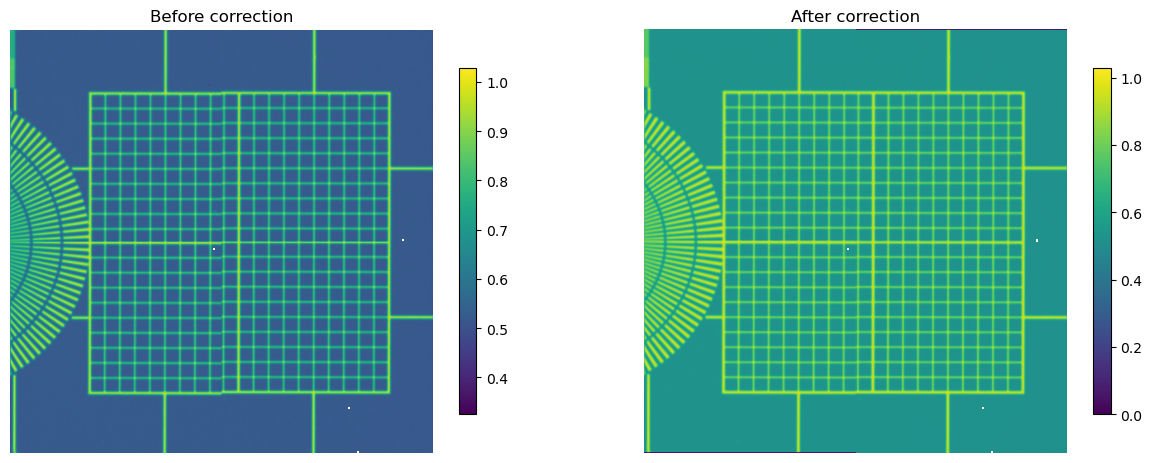

In [19]:
# let's plot the MCP data before and after

# preview
fig, axs = plt.subplots(ncols=2, figsize=(15, 15))
im0 = axs[0].imshow(data_images1)
plt.colorbar(im0, ax=axs[0], shrink=0.3)
axs[0].set_title("Before correction")
axs[0].axis('off')
im1 = axs[1].imshow(new_data_images1)
plt.colorbar(im1, ax=axs[1], shrink=0.3)
axs[1].set_title("After correction")
axs[1].axis('off')
plt.show()